In [1]:
import pymorphy2
from faker import Faker
from mimesis import Person, Finance, Datetime, Address, Internet
from mimesis.locales import Locale
from mimesis.enums import Gender
from mimesis.builtins import RussiaSpecProvider

import numpy as np
import cv2
import json
import os
from tqdm import tqdm
from random import randrange, random, randint, shuffle
from datetime import timedelta, datetime
import subprocess
import re
from collections import defaultdict, deque


# LaTeX template

In [2]:
content = r'''\documentclass[a4paper, 14pt]{extarticle}

\usepackage{cmap}
\usepackage{mathtext}
\usepackage[T2A]{fontenc}
\usepackage[utf8]{inputenc}
\usepackage[english,russian]{babel}
\usepackage{graphicx}
\usepackage{soulutf8}
\usepackage{mathptmx}
\usepackage{tabularx}
\pagenumbering{gobble}

\usepackage{indentfirst}

\usepackage{geometry}
\geometry{top=20mm}
\geometry{bottom=20mm}
\geometry{left=30mm}
\geometry{right=15mm}

\pretolerance10000
\sloppy
\newcommand{\und}{\raisebox{2.5pt}{\_}}

\begin{document}
    \linespread{1.5}
    \selectfont
    \begin{table}[h]
        \hspace{%(logo_shift)s\textwidth}\vspace{%(body_indent)scm}\rotatebox{0}{
        \begin{tabularx}{\textwidth}{
            >{\raggedright\arraybackslash}p{%(logo_shift_correction)s\textwidth}
            >{\raggedleft\arraybackslash}p{0.5\textwidth} }
            \sloppy
            %(center_align)s
            \parbox{10mm}{\includegraphics[width=10mm]{%(logo)s}} 

            %(org_logo_name)s 

            {\fontsize{8}{10}\selectfont %(org_info)s 
                       
            }
            &
            %(header)s \\
            %(center_align)s
            %(mail_date_num)s
            \\
        \end{tabularx}}
    \end{table}

    \begin{center}
        %(reference_text)s    
    \end{center}

    %(main_text)s
    
    \begin{table}[h]
        \begin{tabularx}{\textwidth}{p{0.5\textwidth}
                                    >{\raggedleft\arraybackslash}p{30mm}
                                    >{\raggedleft\arraybackslash}p{0.25\textwidth}}
            %(creator_title)s & 
            \parbox{30mm}{\includegraphics[width=30mm, height=20mm]{%(signature)s}} & 
           
                %(creator_name)s
             
        \end{tabularx}
    \end{table}
    
    {\fontsize{10}{12}\selectfont %(executor_block)s
    
    } 
\end{document}
'''

# На чем генерить данные?

## Faker

In [88]:
fake = Faker('ru_RU')
faker_names = []
for _ in range(1000):
    faker_names.append(fake.name())

len(set(faker_names))

1000

In [23]:
[x for x in faker_names if x.startswith('г-жа')]

['г-жа Михеева Анжелика Олеговна',
 'г-жа Белозерова Анастасия Романовна',
 'г-жа Мельникова Агафья Ивановна',
 'г-жа Суханова Евфросиния Оскаровна']

## Mimesis

In [130]:
from mimesis import Person, Finance, Datetime
from mimesis.locales import Locale
from mimesis.enums import Gender

person = Person(locale=Locale.RU)
fin = Finance(locale=Locale.RU)

fin.company()

'Ritzio Entertainment Group'

In [156]:
companies = [fin.company() for _ in range(10000)]

len(set(companies))

588

In [115]:
dt_data = Datetime(locale=Locale.RU)
dt_data.date(start=2015, end=2023)

datetime.date(2020, 9, 13)

# New generation function

In [3]:
def update_ner_dict(ners_dict, data: str, tag='O', pattern=r"\s+"):
    if tag == 'O':
        for ner in [x for x in re.split(pattern, data) if len(x) > 0]:
            ners_dict[ner].append('O')
            if '-' in ner:
                dash_idxs = [i.end() for i in re.finditer('-', ner)]
                for pos in dash_idxs:
                    if len(ner[:pos]) > 0 and len(ner[pos:]) > 0:
                        ners_dict[ner[:pos]].append('O')
                        ners_dict[ner[pos:]].append('O')
    else:
        for i, ner in enumerate([x for x in re.split(pattern, data) if len(x) > 0]):
            ners_dict[ner].append(f'B-{tag}' if i == 0 else f'I-{tag}')
            if '-' in ner:
                dash_idxs = [i.end() for i in re.finditer('-', ner)]
                for pos in dash_idxs:
                    if len(ner[:pos]) > 0 and len(ner[pos:]) > 0:
                        ners_dict[ner[:pos]].append(f'B-{tag}' if i == 0 else f'I-{tag}')
                        ners_dict[ner[pos:]].append(f'B-{tag}' if i == 0 else f'I-{tag}')
    
    return ners_dict

In [15]:
def get_header_title():
    with open('../samples/titles.txt', 'r', encoding='utf-8') as f:
        titles = f.readlines()
    
    morph = pymorphy2.MorphAnalyzer(lang='ru')

    header_title = ''
    title_tokens = np.random.choice(titles).replace('\n', '').split(' ')

    if '-' in title_tokens[0]:
        title_tokens[0] = title_tokens[0].split('-')[0] + '-' + morph.parse(title_tokens[0].split('-')[1])[0].inflect({'datv'}).word
    if 'ADJF' in morph.parse(title_tokens[0])[0].tag:
        title_tokens[0] = morph.parse(title_tokens[0])[0].inflect({'datv'}).word
        title_tokens[1] = morph.parse(title_tokens[1])[0].inflect({'datv'}).word
    else:
        title_tokens[0] = morph.parse(title_tokens[0])[0].inflect({'datv'}).word
    header_title = ' '.join(title_tokens)

    return header_title.capitalize()

def get_adresat(fake):
    gender = np.random.choice(['male', 'female'])
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    short_flag = random() > 0.5
    
    if gender == 'male':
        adresat_tokens = [fake.last_name_male(), fake.first_name_male(), fake.middle_name_male()]
    else:
        adresat_tokens = [fake.last_name_female(), fake.first_name_female(), fake.middle_name_female()]
    
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    adresat_part = ['Surn', 'Name', 'Patr']
    ref_name = adresat_tokens.copy()

    for i in range(len(adresat_tokens)):
        if len(adresat_tokens[i]) > 0:
            most_likely = morph.parse(adresat_tokens[i])[0]
            for candidat in morph.parse(adresat_tokens[i]):
                if adresat_part[i] in candidat.tag or 'nomn' in candidat.tag: # 'Surn' 'Name', 'Patr'
                    most_likely = candidat
                    if {adresat_part[i], 'nomn'} in candidat.tag:
                        break
            word_datv = most_likely.inflect({'datv', 'sing'})
    
            if word_datv:
                adresat_tokens[i] = word_datv.word
                ref_name[i] = most_likely.inflect({'nomn', 'sing'}).word
    
    if short_flag:
        merge_flag = random() > 0.5

        adresat_tokens[1] = adresat_tokens[1][0] + '.'
        adresat_tokens[2] = adresat_tokens[2][0] + '.'

        ref_name[1] = ref_name[1][0] + '.'
        ref_name[2] = ref_name[2][0] + '.'
        if merge_flag:
            adresat_tokens[1] = adresat_tokens[1] + adresat_tokens[2]
            ref_name[1] = ref_name[1] + ref_name[2]
            
            adresat_tokens = adresat_tokens[:-1]
            ref_name = ref_name[:-1]


    return ' '.join(adresat_tokens).replace('. ', '.\xa0').title(), gender, ' '.join(ref_name)

def get_sender_title(ners_dict):
    with open('../samples/titles.txt', 'r', encoding='utf-8') as f:
        titles = f.readlines()
    creator_title = np.random.choice(titles).replace('\n', '').lower().capitalize()

    ners_dict = update_ner_dict(ners_dict, creator_title, 'JT')
    return creator_title, ners_dict

def get_sender_name(fake, ners_dict):
    gender = np.random.choice(['male', 'female'])
    merge_flag = random() > 0.5

    if gender == 'male':
        creator_tokens = [fake.last_name_male(), fake.first_name_male(), fake.middle_name_male()]
    else:
        creator_tokens = [fake.last_name_female(), fake.first_name_female(), fake.middle_name_female()]

    creator_tokens[1] = creator_tokens[1][0] + '.'
    creator_tokens[2] = creator_tokens[2][0] + '.'

    if merge_flag:
        creator_tokens[1] = creator_tokens[1] + creator_tokens[2]
        
        creator_tokens = creator_tokens[:-1]

    creator_name = ' '.join(creator_tokens).lower().title()

    ners_dict = update_ner_dict(ners_dict, creator_name, 'SND')

    return creator_name.replace('. ', '.\xa0'), ners_dict

def get_executor_name(fake, ners_dict):
    gender = np.random.choice(['male', 'female'])

    if gender == 'male':
        executor_tokens = [fake.last_name_male(), fake.first_name_male(), fake.middle_name_male()]
    else:
        executor_tokens = [fake.last_name_female(), fake.first_name_female(), fake.middle_name_female()]

    executor_name = ' '.join(executor_tokens)

    ners_dict = update_ner_dict(ners_dict, executor_name, 'EXR')

    return executor_name, ners_dict

def get_main_text(ners_dict):
    # [ORG], [PER], [LOC]
    text_sample = np.random.choice(os.listdir('../samples/short_main_texts'))
    with open(f'../samples/short_main_texts/{text_sample}', 'r', encoding='utf-8') as f:
        main_text = f.readlines()

    par_list = [paragraph for paragraph in main_text if len(paragraph) > 0]
    text_str = r' \par '.join(par_list)

    for template in [r'\[ORG\]', r'\[PER\]', r'\[LOC\]']:
        pattern = re.compile(template)
        obj = re.search(pattern, text_str)
        tag = template[2:5]
        while obj is not None:
            entity = get_company_name() if tag == 'ORG' else \
                     get_person() if tag == 'PER' else \
                     Faker('ru_RU').address()
            text_str = text_str[:obj.start()] + entity + text_str[obj.end():]
            ners_dict = update_ner_dict(ners_dict, entity, tag if tag != 'PER' else 'O')
            obj = re.search(pattern, text_str)

    return ners_dict, text_str

def get_person():
    fake = Faker('ru_RU')

    is_male = random() > 0.5

    if is_male:
        return ' '.join([fake.last_name_male(), fake.first_name_male(), fake.middle_name_male()])
    else:
        return ' '.join([fake.last_name_female(), fake.first_name_female(), fake.middle_name_female()])

def generate_org_info(fake, ners_dict):
    org_info_list = [] # org_info = ''
    addr = fake.address()
    postcode_first = random() > 0.5
    if postcode_first:
        addr_tokens = addr.split(' ')
        new_addr = [addr_tokens[-1] + ', '] + addr_tokens[:-1]
        new_addr[-1] = new_addr[-1][:-1]
        addr = ' '.join(new_addr)
    ners_dict = update_ner_dict(ners_dict, addr, 'LOC')
    # org_info += addr + '\n\n'
    org_info_list.append(addr)

    has_phone = random() > 0.5
    has_email = random() > 0.5
    has_inn_kpp = random() > 0.5
    has_url = random() > 0.5

    if has_phone:
        has_fax = random() > 0.5
        fmt = 'cut' if random() > 0.5 else 'full'
        phn = get_phone_number(fake, fmt=fmt)
        ners_dict = update_ner_dict(ners_dict, phn, 'PHN')
        # org_info += 'тел: ' + phn + '\n\n '
        phn_str = 'Тел.: ' + phn
        ners_dict['Тел.:'].append('O')
        if has_fax:
            fax = get_phone_number(fake, fmt=fmt)
            ners_dict = update_ner_dict(ners_dict, fax, 'PHN')
            phn_str += ' Факс: ' + fax
            ners_dict['Факс:'].append('O')

        org_info_list.append(phn_str)

    if has_email:
        mail = fake.ascii_free_email()
        ners_dict[mail].append('B-MAIL')
        mail = mail.replace("_", r"\und")
        # org_info += 'e-mail: '+ mail + '\n\n'
        ners_dict['e-mail:'].append('O')
        org_info_list.append('e-mail: ' + mail)
    if has_url:
        url_gen = Internet()
        url = url_gen.url()
        ners_dict[url].append('O')
        org_info_list.append(url)
    if has_inn_kpp:
        ru = RussiaSpecProvider()
        inn = ru.inn()[:-2]
        kpp = ru.kpp()
        render_case = randint(0, 1)
        has_okpo_ogrn = random() > 0.5
        okpo_ogrn_str = ''
        requisites = []
        
        if render_case == 0:
            inn_kpp_str = f'ИНН: {inn}, КПП: {kpp}'
            ners_dict['ИНН:'].append('O')
            ners_dict['КПП:'].append('O')
            ners_dict[f'{inn},'].append('B-INN')
            ners_dict[kpp].append('B-KPP')
            if has_okpo_ogrn:
                okpo_num = okpo()
                ogrn = ru.ogrn()
                okpo_ogrn_str = f'ОКПО {okpo_num} ОГРН {ogrn}'
                ners_dict = update_ner_dict(ners_dict, okpo_ogrn_str)

        else:
            inn_kpp_str = f'ИНН/КПП {inn} / {kpp}'
            ners_dict['ИНН/КПП'].append('O')
            ners_dict[inn].append('B-INN')
            ners_dict[kpp].append('B-KPP')
            ners_dict['/'].append('O')
            
        requisites.append(inn_kpp_str)
        requisites.append(okpo_ogrn_str)
        shuffle(requisites)
        org_info_list.append('\n\n'.join([req for req in requisites if len(req) > 0]))

    shuffle(org_info_list)

    return '\n\n'.join(org_info_list), ners_dict

def get_company_name():
    fin = Finance(locale=Locale.RU)

    has_type = random() > 0.5
    
    company = fin.company()
    
    if has_type:
        quotes_type = np.random.randint(0, 2)
        company_type = fin.company_type()
        if quotes_type == 0:
            company = re.sub(r'["«»]', '', company)
            company = company_type + f' "{company}"'
        else:
            company = re.sub(r'["«»]', '', company)
            company = company_type + f' «{company}»'

    return company

def okpo():
    tokens = [str(randint(0, 9)) for _ in range(8)]
    return ''.join(tokens)

def get_date_num(ners_dict):
    import locale
    locale.setlocale(locale.LC_ALL, 'ru_RU.utf-8')

    mail_num = str(np.random.randint(1, 1000000))
    mail_num = '0' * max(0, (3 - len(mail_num))) + mail_num
    dt_gen = Datetime(locale=Locale.RU)

    date_type = np.random.randint(0, 3)

    date = dt_gen.date(start=2000, end=2024).strftime('%d.%m.%Y') if date_type == 0 else \
           dt_gen.formatted_date('«%d» %B %Y') + 'г.' if date_type == 1 else \
           dt_gen.formatted_date('«%d» %b %Y') + 'г.'
    
    ners_dict = update_ner_dict(ners_dict, mail_num, 'MN')
    ners_dict = update_ner_dict(ners_dict, date, 'DS')

    block_pattern = np.random.randint(0, 2)

    if block_pattern == 0:
        block = r'\ul{%(date)s № %(mail_num)s}' + '\n\n' + r'\underline{\raisebox{2pt}{на № %(date2)s от %(num2)s}} &'
        has_source = random() > 0.5
        date2 = r'\hspace{10mm}'
        num2 = r'\hspace{10mm}'

        ners_dict['№'].append('O')
        ners_dict['на'].append('O')
        ners_dict['№'].append('O')
        ners_dict['от'].append('O')

        if has_source:
            date2 = Datetime(locale=Locale.RU).date(start=2000, end=2024).strftime('%d.%m.%Y')
            num2 = str(np.random.randint(1, 1000000))
            ners_dict[date2].append('O')
            ners_dict[num2].append('O')

        return ners_dict, block % {
            'date': date,
            'mail_num': mail_num,
            'date2': date2,
            'num2': num2
        }
    else:
        block = r'Исх. № \ul{%(mail_num)s} от %(date)s'
        is_right = random() > 0.5

        ners_dict['Исх.'].append('O')
        ners_dict['№'].append('O')
        ners_dict['от'].append('O')

        if is_right:
            block = ' & ' + block
            return ners_dict, block % {'mail_num': mail_num, 'date': date}
        else:
            has_source = random() > 0.5
            if has_source:
                date2 = Datetime(locale=Locale.RU).date(start=2000, end=2024).strftime('%d.%m.%Y')
                num2 = str(np.random.randint(1, 1000000))

                block += '\n\n' + r' На %(num2)s от %(date2)s &'

                ners_dict['На'].append('O')
                ners_dict['от'].append('O')
                ners_dict[date2].append('O')
                ners_dict[num2].append('O')
                
                return ners_dict, block % {
                    'date': date,
                    'mail_num': mail_num,
                    'date2': date2,
                    'num2': num2
                }
            return ners_dict, block % {
                'date': date,
                'mail_num': mail_num
            }

def get_phone_number(fake, fmt='cut'):
    phn = fake.phone_number()
    if len(phn.split(' ')) > 2 and fmt == 'cut':
        phn = ' '.join(phn.split(' ')[1:])
    return phn

def get_executor_info(ners_dict, fake):   
    has_fax = random() > 0.5
    has_email = random() > 0.5
    fmt = 'cut' if random() > 0.5 else 'full'
    block = ''

    executor_name, ners_dict = get_executor_name(fake, ners_dict)
    block += 'Исп. ' + executor_name + '\n\n'
    ners_dict['Исп.'].append('O')

    contact_list = []
    phn = get_phone_number(fake, fmt=fmt)
    contact_list.append(f'Тел.: {phn}')
    ners_dict = update_ner_dict(ners_dict, phn, 'PHN')
    ners_dict['Тел.:'].append('O')
    if has_fax:
        fax = get_phone_number(fake, fmt=fmt)
        contact_list.append(f'Факс: {fax}')
        ners_dict = update_ner_dict(ners_dict, fax, 'PHN')
        ners_dict['Факс:'].append('O')
    if has_email:
        email = fake.ascii_free_email()
        contact_list.append(f'E-mail: {email}')
        ners_dict = update_ner_dict(ners_dict, email, 'MAIL')
        ners_dict['E-mail:'].append('O')
    
    shuffle(contact_list)

    return block + '\n\n'.join(contact_list)
   


In [5]:
# print(re.search(r'\[ORG\]', 'asdasd [ORG] asdas [ORG]'))
# 'asdasd [ORG] asdas'[:7]
# i = 5
# while i > 0:
#     print(i)
#     i -= 1

In [80]:
from random import shuffle
a = [1, 2, 3]
shuffle(a)
a

[3, 2, 1]

In [83]:
ru = RussiaSpecProvider()
inn = ru.inn()
kpp = ru.kpp()
ru.kpp()

'060048535'

In [363]:
# Datetime(locale=Locale.RU).month(abbr=True)
'0' * 0
import locale
locale.setlocale(locale.LC_ALL, 'ru_RU.utf-8')
Datetime(locale=Locale.RU).month()
Datetime(locale=Locale.RU).formatted_date('«%d» %B %Y')

'«08» Июль 2017'

In [364]:
r'\ul{%(date)s № %(mail_num)s} \n\n \underline{\raisebox{2pt}{на № %(date2)s от %(num2)s}}' % {'date': '01.01.2019', 'mail_num': '12314', 'date2': r'\hspace{10mm}', 'num2': r'\hspace{10mm}'}
r'Исх. № \ul{%(mail_num)s} от %(date)s'

'Исх. № \\ul{%(mail_num)s} от %(date)s'

In [29]:
def new_generate_mail_data():
    fake = Faker('ru_RU')
    ners_dict = defaultdict(deque)
    
    # logo
    logo_img = np.random.choice(os.listdir(os.path.join('..', 'samples', 'logo')))
    logo = '/'.join(['..', 'samples', 'logo', logo_img])

    org_logo_name = get_company_name()
    ners_dict = update_ner_dict(ners_dict, org_logo_name, 'ORG')
    org_info, ners_dict = generate_org_info(fake, ners_dict)

    # date = Datetime(locale=Locale.RU).date(start=2000, end=2024).strftime('%d.%m.%Y')
    # ners_dict[date].append('B-DS')

    # mail_num = fake.postcode()
    # ners_dict[mail_num].append('B-MN')
    # ners_dict['№'].append('O')
    # ners_dict['на'].append('O')
    # ners_dict['№'].append('O')
    # ners_dict['от'].append('O')
    ners_dict, mail_date_num = get_date_num(ners_dict)

    # header
    header_case = np.random.randint(2) # 0 - title? + adresat + org, 1 - 2 or more orgs, 2 -  
    if header_case == 0:
        has_title = random() > 0.5
        header_title = ''
        if has_title:
            header_title = get_header_title()
            ners_dict = update_ner_dict(ners_dict, header_title, 'JT')
        
        adresat, gender, ref_name = get_adresat(fake)
        ners_dict = update_ner_dict(ners_dict, adresat, 'ADR')

        org = get_company_name() # Finance(locale=Locale.RU).company()
        ners_dict = update_ner_dict(ners_dict, org, 'ORG')

        header = header_title + ' ' + org + ' ' + adresat

        has_ref = random() > 0.5
        reference_text = ''
        if has_ref:
            ref_start = 'Уважаемый ' if gender == 'male' else 'Уважаемая '
            ref_per = ref_name.title().strip()
            reference_text = ref_start + ref_per + '!'
            ners_dict[ref_start.strip()].append('O')
            ners_dict = update_ner_dict(ners_dict, ref_per + '!', 'ADR')
    elif header_case == 1:
        # fin = Finance(Locale.RU)
        org_count = np.random.randint(2, 4)
        header = ''
        for _ in range(org_count):
            org = get_company_name()
            header += org
            header += '\n\n\n'
            ners_dict = update_ner_dict(ners_dict, org, 'ORG')

        reference_text = ''

    # main_text
    ners_dict, main_text = get_main_text(ners_dict)
    ners_dict = update_ner_dict(ners_dict, main_text.replace(r'\par', '\n'))
    main_text = main_text.replace('"', '"{}')
    # creator
    creator_title, ners_dict = get_sender_title(ners_dict)
    sender_name, ners_dict = get_sender_name(fake, ners_dict)
    signature_img = np.random.choice(os.listdir(os.path.join('..', 'samples', 'signature')))
    signature = '/'.join(['..', 'samples', 'signature', signature_img])

    # executor
    has_executor = random() > 0.5
    executor_block = ''
    if has_executor:
        executor_block = get_executor_info(ners_dict, fake)

    return logo, org_logo_name, org_info, mail_date_num, header, reference_text, main_text, creator_title, sender_name, signature, executor_block, ners_dict

In [234]:
fake = Faker('RU_ru')

# all([fake.address().split(' ')[-1].isdigit() for _ in range(1000)])
# fake.address()
Finance(locale=Locale.RU).company()

'Концерн «Тракторные заводы»'

# Generate JPG and layout

In [7]:
def get_word_boxes_old(img_arr, white_px_count=5, white_px_thresh=254):
    # img_arr = img_arr[:-2, :, :]
    px_sum = img_arr.mean(axis=(0, 2))
    word_borders = []
    white_count = 0
    for i, col in enumerate(px_sum):
        if col > white_px_thresh:
            white_count += 1
        else:
            if i - white_count <= 0:
                word_borders.append(i)
            elif white_count > white_px_count:
                word_borders.append(i - white_count)
                word_borders.append(i)
            white_count = 0
        if i == len(px_sum) - 1:
            word_borders.append(i - white_count)

    return word_borders

# plt.imshow(cv2.threshold(cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY), 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1], cmap='gray')
def get_word_boxes(img_arr, white_px_count=5, white_px_thresh=254):
    img_thresh = cv2.threshold(cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY), 180, 255, cv2.THRESH_BINARY)[1]
    
    px_sum = img_thresh.mean(axis=0)
    word_borders = []
    white_count = 0
    for i, col in enumerate(px_sum):
        if col > white_px_thresh:
            white_count += 1
        else:
            if i - white_count <= 0:
                word_borders.append(i)
            elif white_count > white_px_count:
                word_borders.append(i - white_count)
                word_borders.append(i)
            white_count = 0
        if i == len(px_sum) - 1:
            word_borders.append(i - white_count)

    return word_borders

In [8]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer
import os
import pandas as pd
import pdf2image
import numpy as np
import PIL
from PIL import Image
import io
from pathlib import Path
import json
import re

def generate_jpg_and_layout(pdf_path, filename, ners_dict, out_dir='../latex_letters/'): #, tags_per_clusters
    with open(pdf_path, 'rb') as fp:
        parser = PDFParser(fp)
        document = PDFDocument(parser)

        if not document.is_extractable:
            raise PDFTextExtractionNotAllowed
        
        rsrcmgr = PDFResourceManager()
        # device = PDFDevice(rsrcmgr)
        laparams = LAParams(line_margin=0.3)
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        boxes_line_data = []
        page_sizes = []

        boxes = []
        words = []
        ners = []

        def parse_obj(lt_objs, verbose=0):
            for obj in lt_objs:
                if isinstance(obj, pdfminer.layout.LTTextBoxHorizontal):
                    if verbose > 0:
                        print('%6d, %6d, %s' % (obj.bbox[0], obj.bbox[1], obj.get_text()))

                    data_dict = {
                        "startX": round(obj.bbox[0]),
                        "startY": round(obj.bbox[1]),
                        "endX": round(obj.bbox[2]),
                        "endY": round(obj.bbox[3]),
                        "text": obj.get_text()
                    }

                    boxes_line_data.append(data_dict)
                elif isinstance(obj, pdfminer.layout.LTFigure):
                    parse_obj(obj._objs)
        
        for page in PDFPage.create_pages(document):
            interpreter.process_page(page)
            layout = device.get_result()
            parse_obj(layout._objs)
            mediabox = page.mediabox
            mediabox_data = { "height": mediabox[-1], "width": mediabox[-2] }
            page_sizes.append(mediabox_data)

        firstpage_size = page_sizes[0]
        firstpage_image = pdf2image.convert_from_path(pdf_path, poppler_path=r'..\poppler-23.11.0\Library\bin')[0]
        firstpage_image.save(os.path.join(out_dir, 'jpg', f'{filename}.jpg'))

        dpi = 200/72
        vertical_shift = 5
        page_height = int(firstpage_size['height'] * dpi)

        boxes_line_data = sorted(boxes_line_data, key=lambda x: -x["startY"])
        for i in range(len(boxes_line_data)):

            startX, startY, endX, endY, text = boxes_line_data[i].values()
            startX = max(0, startX)
            
            # PDF -> PIL
            startY = page_height - int(startY * dpi) - vertical_shift
            endY = page_height - int(endY * dpi) - vertical_shift
            startX = int(startX * dpi)
            endX = int(endX * dpi)
            startY, endY = endY, startY
            endY += 4
            
            image_array = np.array(firstpage_image)
            box = image_array[startY:endY, startX:endX,:]
            
            word_borders = get_word_boxes(box, white_px_count=8)
            for ix, word in zip(range(0, len(word_borders)-1, 2), [word for word in re.split('\s+', text) if len(word) > 0]):
                if word_borders[ix+1] - word_borders[ix] > 3:
                    boxes.append([[startX+word_borders[ix], startY],
                                    [startX+word_borders[ix+1], endY]])
                    words.append(word)
                    if word in ners_dict:
                        if len(ners_dict[word]) > 0:
                            ners.append(ners_dict[word].popleft())
                        else:
                            ners.append('UNK1')
                    else:
                        ners.append('UNK')
            # if i == len(boxes_line_data) - 2:
            #     word_borders = get_word_boxes(box, white_px_count=3, white_px_thresh=252)
            #     for ix, word in zip(range(0, len(word_borders)-1, 2), [word for word in re.split('\s+', text) if len(word) > 0]):
            #         if word_borders[ix+1] - word_borders[ix] > 3:
            #             boxes.append([[startX+word_borders[ix], startY],
            #                           [startX+word_borders[ix+1], endY]])
            #             words.append(word)
            # elif i == len(boxes_line_data) - 1:
            #     boxes.append([[startX, startY],
            #                   [endX, endY]])
            #     words.append(text)
            # else:
            #     word_borders = get_word_boxes(box, white_px_count=7)
            #     for ix, word in zip(range(0, len(word_borders)-1, 2), [word for word in re.split('\s+', text) if len(word) > 0]):
            #         if word_borders[ix+1] - word_borders[ix] > 3:
            #             boxes.append([[startX+word_borders[ix], startY],
            #                           [startX+word_borders[ix+1], endY]])
            #             words.append(word)
    json_data = {
        'filename': f'{filename}.jpg', 
        'boxes': boxes,
        'words': words,
        'ner_tags': ners
    }

    with open(os.path.join(out_dir, 'json', f'{filename}.json'), 'w', encoding='utf-8') as f:
        json.dump(json_data, f)

    with open(os.path.join(out_dir, 'box_tl', f'{filename}.json'), 'w', encoding='utf-8') as f:
        json.dump(boxes_line_data, f)


In [9]:
def generate_layout_shifts():
    shifts = {}
    shift_range = list(np.arange(-0.15, 0.25, 0.1)) + [0.]
    shifts['logo_shift'] = np.round(np.random.choice(shift_range), 2)
    shifts['logo_shift_correction'] = 0.5 - shifts['logo_shift']
    shifts['body_indent'] = np.random.choice([-1, -0.5])

    has_center_align = random() > 0.5
    center_align = ''
    if has_center_align:
        center_align = r'\centering'
    shifts['center_align'] = center_align

    return shifts

# Insert data into template

# Data generation pipeline

In [30]:
import copy
dicts = []
for i in tqdm(range(1000)):
    logo, org_logo_name, org_info, mail_date_num, header, reference_text, main_text, creator_title, creator_name, signature, executor_block, ners_dict = new_generate_mail_data()
    layout_shifts = generate_layout_shifts()
    dicts.append(copy.deepcopy(ners_dict))
    # build tex
    kwargs = {
            "logo": logo,
            "org_logo_name": org_logo_name.replace('" ', '"\ ').replace('&', '\&'),
            "org_info": org_info,
            "mail_date_num": mail_date_num,
            "header": header.replace('" ', '"\ ').replace('&', '\&'),
            "reference_text": reference_text,
            "main_text": main_text, # r' \par '.join(main_text).replace('" ', '"\ '),
            "creator_title": creator_title,
            "creator_name": creator_name,
            "signature": signature,
            "executor_block": executor_block.replace("_", r"\und"),
            "logo_shift": layout_shifts['logo_shift'],
            "logo_shift_correction": layout_shifts['logo_shift_correction'],
            "body_indent": layout_shifts['body_indent'],
            "center_align": layout_shifts['center_align']
        }

    with open(f'../latex_letters/tex/{i}.tex', 'w', encoding='utf-8') as f:
        f.write(content % kwargs)

    # build pdf
    cmd = ["pdflatex", "-interaction", "nonstopmode", "-output-directory", "../latex_letters/pdf",  f"../latex_letters/tex/{i}.tex"]  
    proc = subprocess.Popen(cmd)
    proc.communicate()

    os.remove(f'../latex_letters/pdf/{i}.aux')
    os.remove(f'../latex_letters/pdf/{i}.log')

    # build jpg and layout
    generate_jpg_and_layout(f'../latex_letters/pdf/{i}.pdf', i, ners_dict)
    

  0%|          | 2/1000 [00:03<25:32,  1.54s/it]

In [24]:
for i in range(1000):
    with open(f'../latex_letters/json/{i}.json', 'r') as f:
        layout = json.load(f)
    if 'UNK' in layout['ner_tags']:
        print(i)
    
print('end')

2
7
9
27
29
31
43
53
58
61
63
85
96
105
107
114
116
121
125
129
134
142
147
152
155
156
157
162
166
173
175
176
180
187
190
193
207
210
223
227
237
252
255
258
262
268
272
285
300
306
307
310
312
314
323
325
332
342
348
356
358
362
365
370
374
389
391
397
401
402
409
413
415
419
425
429
432
434
437
442
445
451
453
474
487
489
491
499
502
514
527
533
542
549
553
557
560
564
598
602
606
618
620
640
650
652
658
661
675
676
681
683
691
694
708
709
712
715
716
721
724
728
730
732
734
749
764
775
777
778
781
789
790
791
792
808
818
819
824
825
835
844
845
851
853
854
861
866
874
891
894
896
907
920
931
940
947
950
952
955
957
958
961
965
974
978
980
984
997
999
end


In [28]:
dicts[2].keys()

dict_keys(['Акционерное', 'общество', '«Аромалюкс»', 'с.', 'Тосно,', 'алл.', '50', 'лет', 'Октября,', 'д.', '2/2,', '201764', 'jartemev@hotmail.com', 'e-mail:', 'ИНН:', 'КПП:', '4319558225,', '310037270', '494700', '29.04.2022', 'Исх.', '№', 'от', 'Начальнику', 'отдела', 'кадров', 'Большаковой', 'И.', 'Ж.', 'Миэль-Недвижимостъ', 'Миэль-', 'Недвижимостъ', 'Уважаемая', 'Большакова', 'Ж.!', 'Общество', 'с', 'ограниченной', 'ответственностью', '"Автотор"', 'Обращаюсь', 'к', 'вам', 'просьбой', 'предоставить', 'информацию', 'о', 'текущей', 'конфигурации', 'оборудования.', 'Просим', 'вас', 'следующую', 'по', 'каждому', 'устройству:', 'Наименование', 'Модель', 'и', 'серийный', 'номер', '(если', 'применимо).', 'Технические', 'характеристики.', 'Просьба', 'эту', 'в', 'течение', '3', '(трех)', 'дней', 'для', 'обеспечения', 'своевременного', 'обновления', 'наших', 'баз', 'данных.', 'Специалист', 'первой', 'категории', 'службы', 'ит', 'Зиновьев', 'Р.Т.', 'Игнатов', 'Филарет', 'Якубович', 'Исп.', '8

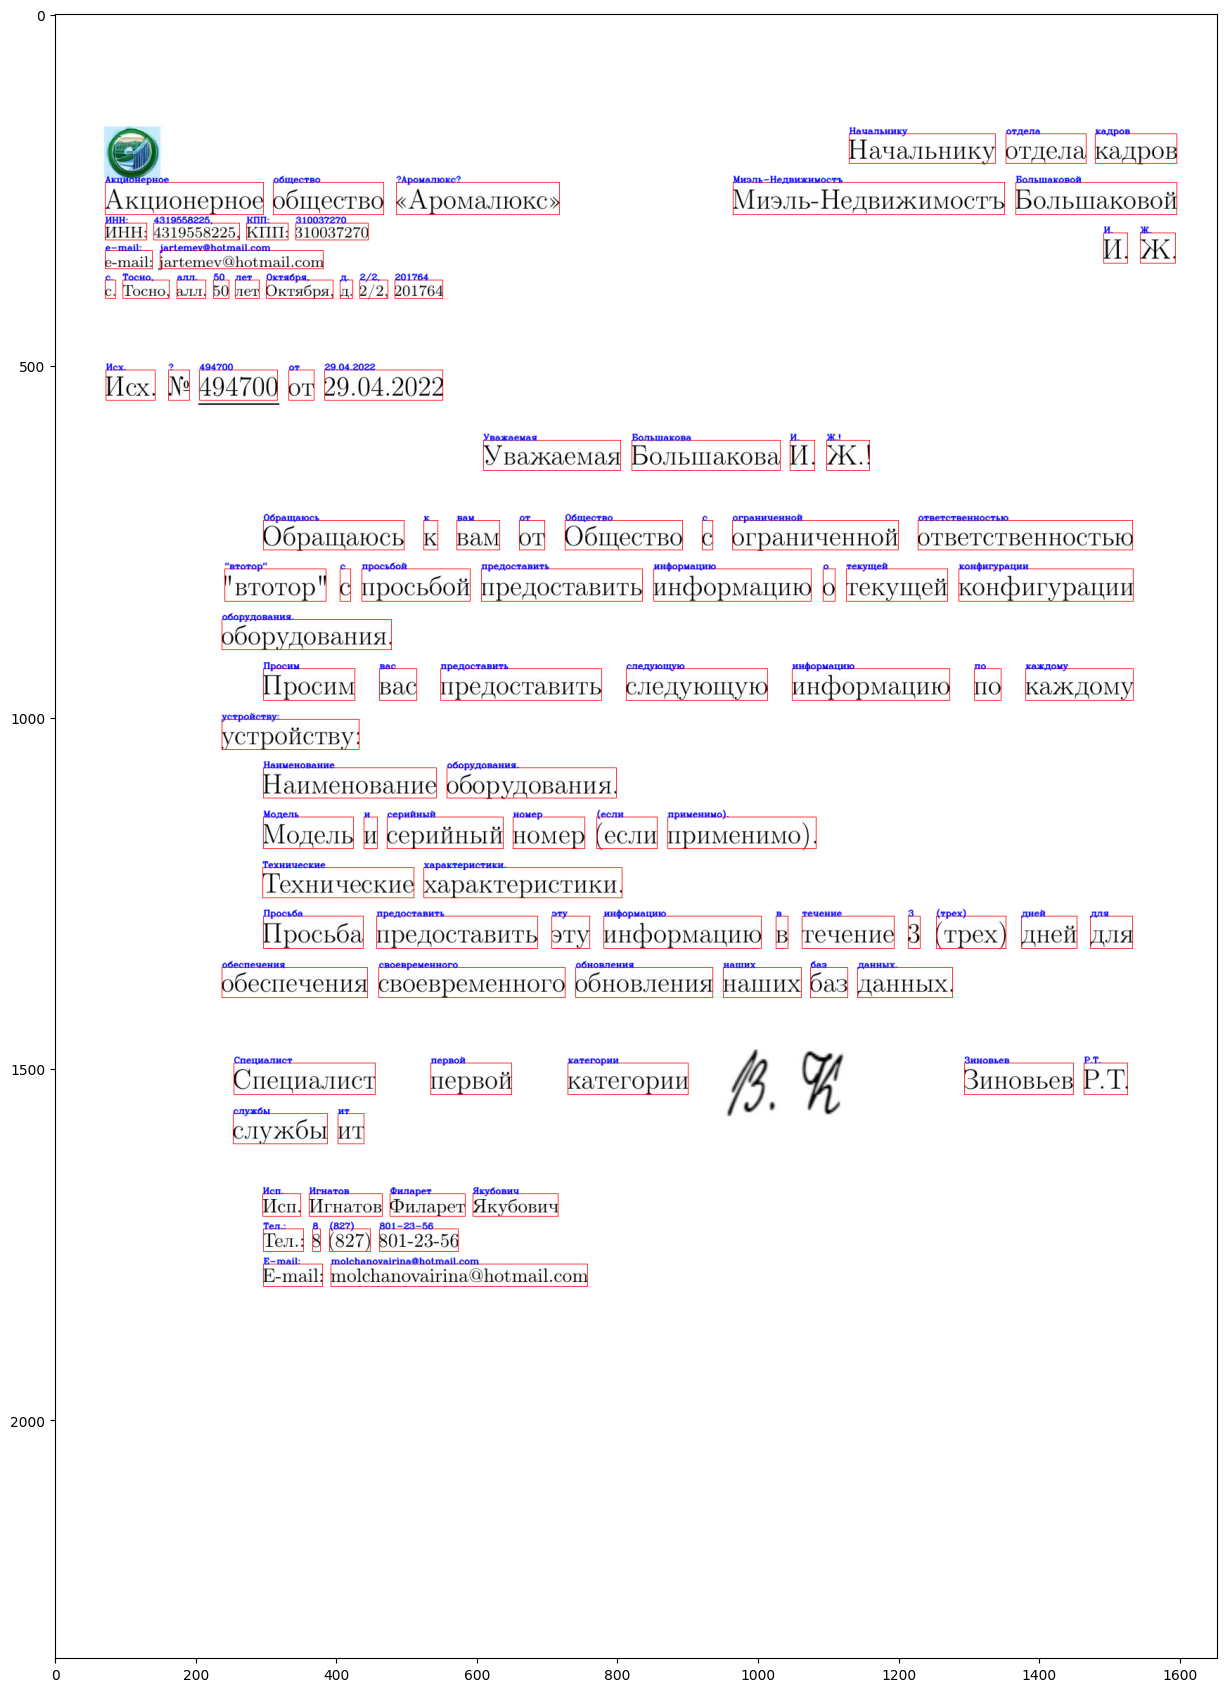

In [26]:
import cv2
import matplotlib.pyplot as plt

n = 2
img = cv2.imread(f'../latex_letters/jpg/{n}.jpg')
with open(f'../latex_letters/json/{n}.json', 'r') as f:
    layout = json.load(f)

for box, word in zip(layout['boxes'], layout['words']):
    img = cv2.rectangle(img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (255, 0, 0), 1)
    img = cv2.putText(img, word, (box[0][0], box[0][1]), cv2.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 255), 1, cv2.LINE_AA)

plt.figure(figsize=(15, 25))
plt.imshow(img)

In [335]:
layout['words'][110:]# elizar_1980@mail.ru

['Е.',
 'В.',
 'отдела',
 'разработки',
 'пользовательских',
 'интерфейсов',
 'Меркушев',
 'Авдей',
 'Артурович',
 '(571)',
 '374-9962']

In [336]:
[word for word in layout['words'] if word == '+7']

[]

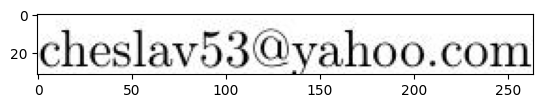

In [105]:
img = cv2.imread(f'latex_letters/jpg/{n}.jpg')
with open(f'latex_letters/box_tl/{n}.json', 'r') as f:
    layout = json.load(f)

dpi = 200/72
vertical_shift = 5
page_height = int(841.89 * dpi)
# (startX, startY), (endX, endY) = layout['boxes'][19]


el_n = -1
startX = layout[el_n]['startX']
startY = layout[el_n]['startY']
endX = layout[el_n]['endX']
endY = layout[el_n]['endY']
startY = page_height - int(startY * dpi) - vertical_shift
endY = page_height - int(endY * dpi) - vertical_shift
startX = int(startX * dpi)
endX = int(endX * dpi)
startY, endY = endY, startY
endY += 4
fragment = img[startY:endY, startX:endX]
plt.imshow(fragment);
# plt.bar(np.arange(fragment.shape[1]), (fragment / 255).sum(axis=(0, 2)) / 10)

In [59]:
fragment.mean(axis=(0,2))[35:55]

array([245.43181818, 248.        , 244.54545455, 236.56818182,
       254.90909091, 254.90909091, 254.90909091, 254.90909091,
       254.90909091, 254.90909091, 254.90909091, 254.90909091,
       254.59090909, 254.81818182, 254.31818182, 254.68181818,
       254.65909091, 254.45454545, 254.40909091, 249.79545455])

In [43]:
layout

[{'startX': 481,
  'startY': 765,
  'endX': 575,
  'endY': 779,
  'text': '«Tele2 Россия»\n'},
 {'startX': 463,
  'startY': 739,
  'endX': 575,
  'endY': 754,
  'text': 'Сеть магазинов H\n'},
 {'startX': 190,
  'startY': 739,
  'endX': 328,
  'endY': 754,
  'text': '«Высококачественные\n'},
 {'startX': 211,
  'startY': 714,
  'endX': 307,
  'endY': 728,
  'text': 'автомобильные\n'},
 {'startX': 234, 'startY': 688, 'endX': 284, 'endY': 703, 'text': 'дороги»\n'},
 {'startX': 196,
  'startY': 675,
  'endX': 322,
  'endY': 683,
  'text': 'к. Каспийск, ш. Сахалинское, д.\n'},
 {'startX': 238,
  'startY': 660,
  'endX': 281,
  'endY': 668,
  'text': '4/7, 611883\n'},
 {'startX': 208,
  'startY': 645,
  'endX': 311,
  'endY': 653,
  'text': 'ИНН: 476108170318, КПП:\n'},
 {'startX': 240,
  'startY': 630,
  'endX': 278,
  'endY': 638,
  'text': '995570141\n'},
 {'startX': 197,
  'startY': 603,
  'endX': 321,
  'endY': 618,
  'text': '23.11.2014 № 158576\n'},
 {'startX': 202, 'startY': 578, 'end

In [318]:
# layout[el_n]
[word for word in re.split('\s+', '+7 (571) 374-9962\n') if len(word) > 0]

['+7', '(571)', '374-9962']

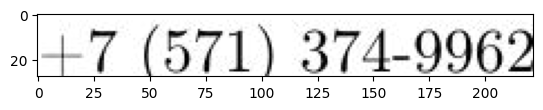

In [339]:
plt.imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY), cmap='gray')

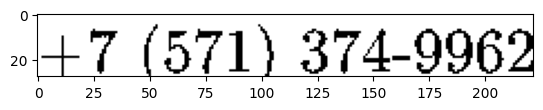

In [341]:
thresh_value, fragm_thresh = cv2.threshold(cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY), 180, 255, cv2.THRESH_BINARY)
plt.imshow(fragm_thresh, cmap='gray')

In [316]:
fragm_thresh.mean(axis=0)[100:125]

array([245.89285714, 236.78571429, 218.57142857, 163.92857143,
       136.60714286, 236.78571429, 255.        , 255.        ,
       255.        , 255.        , 255.        , 255.        ,
       255.        , 255.        , 255.        , 255.        ,
       255.        , 255.        , 255.        , 218.57142857,
       173.03571429, 191.25      , 227.67857143, 227.67857143,
       227.67857143])

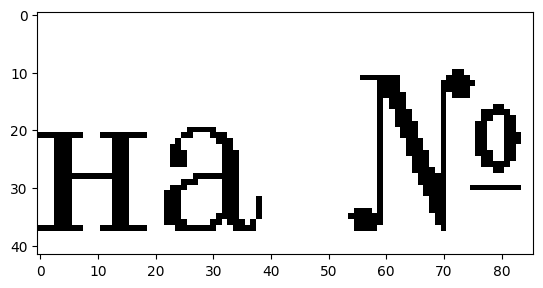

In [296]:
plt.imshow(cv2.threshold(fragment, 180, 255, cv2.THRESH_BINARY)[1], cmap='gray')

# Generating data experimenting

In [50]:
from mimesis import Person, Finance, Datetime
from mimesis.locales import Locale
from mimesis.enums import Gender

Finance(locale=Locale.RU).company()

'Торговая сеть «Монетка»'

In [76]:
from faker import Faker
fake = Faker('ru_RU')
len(set([fake.job() for _ in range(10000)]))

517

In [16]:
from mimesis import Address

Address(locale=Locale.RU).address()

'ул. Яуза Платформа 922'

In [36]:
from mimesis.builtins import RussiaSpecProvider

ru = RussiaSpecProvider()

ru.kpp()

'350027406'

In [31]:
fake = Faker('ru_RU')
fake.address()

'к. Поронайск, ш. Февральское, д. 71 к. 6/6, 135423'

In [33]:
fake.ascii_free_email()

'shilovaelena@gmail.com'

In [5]:
with open('samples/titles.txt', 'r', encoding='utf-8') as f:
    titles = f.readlines()

titles

['генеральный директор\n',
 'Главный бухгалтер\n',
 'Специалист первой категории бухгалтерии\n',
 'Специалист второй категории бухгалтерии\n',
 'Руководитель Службы ИТ\n',
 'Специалист первой категории Службы ИТ\n',
 'Специалист второй категории Службы ИТ\n',
 'Специалист третьей категории Службы ИТ\n',
 'Руководитель Административно-хозяйственного отдела\n',
 'Специалист первой категории административно-хозяйственного отдела\n',
 'Специалист второй категории административно-хозяйственного отдела\n',
 'Начальник отдела кадров\n',
 'Специалист первой категории отдела кадров\n',
 'Специалист второй категории отдела кадров\n',
 'Специалист третьей категории отдела кадров\n',
 'Директор Департамента разработки\n',
 'Руководитель отдела разработки систем\n',
 'Руководитель отдела разработки пользовательских интерфейсов\n',
 'Руководитель отдела проектирования\n',
 'Руководитель отдела тестирования\n',
 'Руководитель отдела архитектуры\n',
 'Директор Департамента внедрения и эксплуатации\n',